In [1]:
#%% Load Modules
startup_file='init_python.py'
exec(open(startup_file).read())

In [2]:
# parameters 

#number of ensembles
N_ensemble=3

#define the start/end files for plotting
file_start = 1
file_end = 250

#time between files (0.5 factor due to change in equation)
dt = 0.5*1.e-3

#forcing scale
kf = 512
wf = kf**2.0
L = 2.0*np.pi
N = 2048

#fluxes defined from initial forcing
wave_action_flux = 2.0 * 32.12
energy_flux = 2.0 * 8.41969e6

#fit regions for T/mu
kmin_low=1
kmax_low = 5

#fit regions for T/\omega
kmin_high=200
kmax_high=400

#if true then fit spectum by max. Default is average across modes
simon_fitting = False

In [3]:
def Gibbs_function(x,a):
    return 1.0/( (x/a) + 1.0)

In [4]:
n_k = np.zeros(N)

temp = np.zeros(file_end-file_start+1)
mu =  np.zeros(file_end-file_start+1)
time = np.zeros(file_end-file_start+1)
energy_series = np.zeros([file_end-file_start+1,5])
waveaction_series = np.zeros([file_end-file_start+1,3])


In [5]:
index = 0
for file_num in range(file_start,file_end+1,1):

	file_time = file_num * dt
	n_k = 0.0
	waveaction = 0.0
	energy = 0.0
	#average over ensembles
	for ensemble_num in range(1,N_ensemble+1,1):
		filename = '/data2/2d_gp_selfsimilar/decay_at_512_ensemble_%.1d/output/spectrum.%.5d' % (ensemble_num,file_num);
		filename2 = '/data2/2d_gp_selfsimilar/decay_at_512_ensemble_%.1d/output/energy.%.5d' % (ensemble_num,file_num);
		filename3 = '/data2/2d_gp_selfsimilar/decay_at_512_ensemble_%.1d/output/waveaction.%.5d' % (ensemble_num,file_num);

		data1 = np.loadtxt(filename)
		n_k += data1[:,1]
		data2 = np.loadtxt(filename2)
		energy += data2
		data3 = np.loadtxt(filename3)
		waveaction += data3
	
	n_k /= N_ensemble   # this is the 2d spectrum  
	energy /= N_ensemble    
	waveaction /= N_ensemble   

	k = data1[:,0]

	n_omega = n_k[1:]/(2.0*k[1:]) 	# n_2d/2k = 1d sepctrum in freq space
	omega = k[1:]**2				# omega = k**2


	if file_num == file_start:
		total_wave_action = np.sum(n_k)
		total_energy = 0.5 * np.sum(k * k * n_k)

	if simon_fitting:
		maxN= np.max(n_omega[0:(kf//2)])
		maxN_index = np.argmax(n_omega[0:(kf//2)])
		n_omega /= maxN
		omega_fit = omega[0:7*kf//8]
		n_fit = n_omega[0:7*kf//8]

		opt, pcov = curve_fit(Gibbs_function, omega_fit, n_fit)

		time[index] = file_num*dt
		temp[index] = opt * maxN
		mu[index] = opt
		energy_series[index,:] = energy[:]
		waveaction_series[index,:] = waveaction[:]
		
		index=index+1
	else:
		maxN= np.mean(n_omega[kmin_low:kmax_low])
		n_omega /= maxN
		omega_fit = omega[0:7*kf//8]
		n_fit = n_omega[0:7*kf//8]

		opt, pcov = curve_fit(Gibbs_function, omega_fit, n_fit)

		time[index] = file_num*dt
		temp[index] = opt * maxN
		mu[index] = opt
		energy_series[index,:] = energy[:]
		waveaction_series[index,:] = waveaction[:]
		
		index=index+1


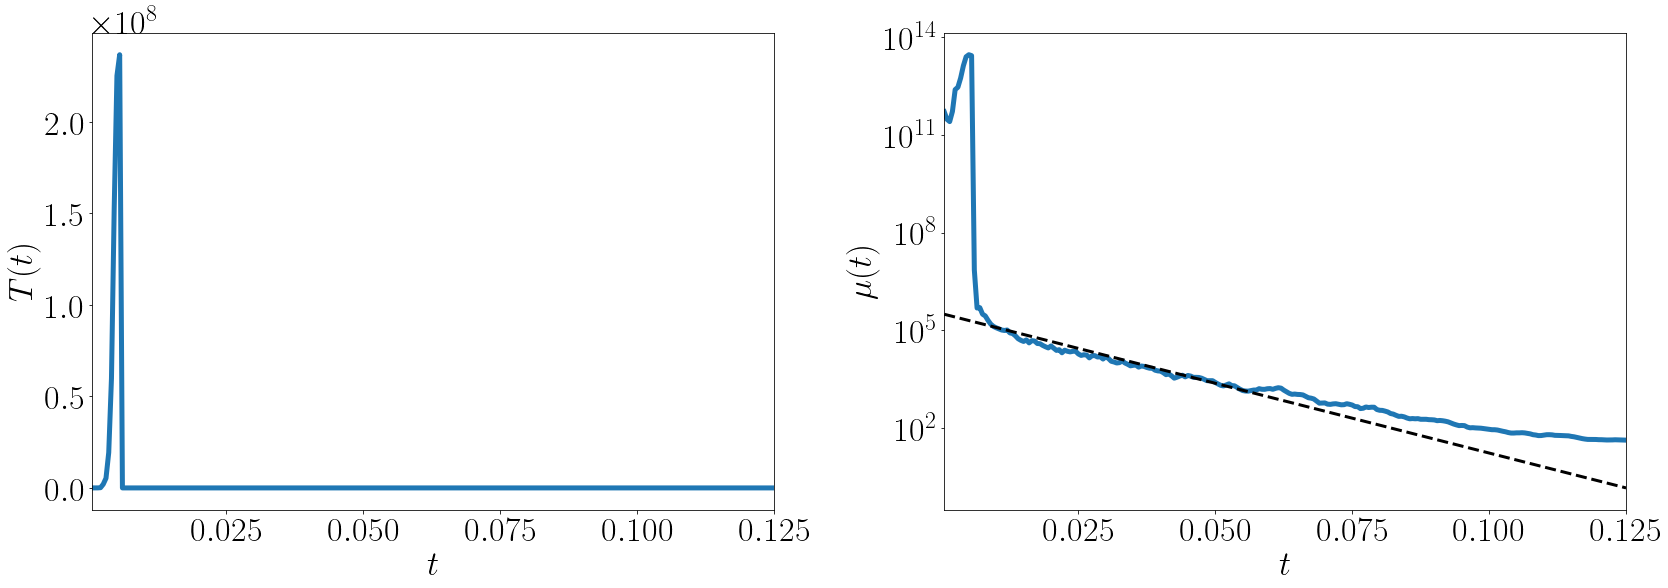

In [6]:
fig1, axs1 = newfig(1, 2)

mu0 = mu[100]
temp0 = temp[100]
time0 = time[100]

mu_fit = mu0*np.exp(-1.0*wave_action_flux*(time-time0)/temp0)

axs1[0].plot( time,temp, linestyle='-',linewidth=5)#,label=r'Numerics')	
axs1[1].plot( time,mu, linestyle='-',linewidth=5)#,label=r'Numerics')	
axs1[1].plot( time, mu_fit, linestyle='dashed',linewidth=3, color='black')

axs1[0].set_xlim(file_start*dt,file_end*dt)	
axs1[1].set_xlim(file_start*dt,file_end*dt)		

#axs1[0].set_ylim(0,2)	

	
axs1[0].set_xlabel(r'$t$')
axs1[0].set_ylabel(r'$T(t)$')
axs1[1].set_xlabel(r'$t$')
axs1[1].set_ylabel(r'$\mu(t)$')


axs1[1].set_yscale('log')

fig1.tight_layout()

fig1.savefig('temp_mu_decay.pdf')

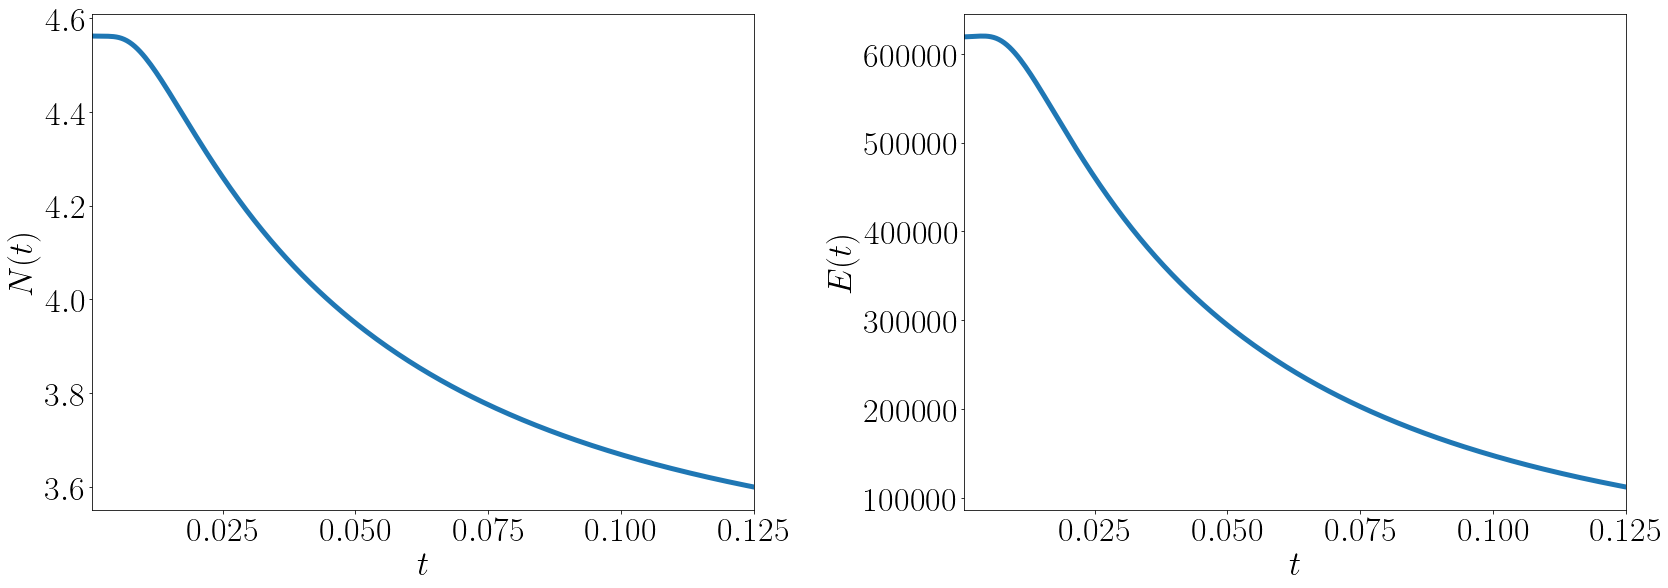

In [7]:
fig2, axs2 = newfig(1, 2)



axs2[0].plot( time,waveaction_series[:,1]/(L*L), linestyle='-',linewidth=5)#,label=r'Numerics')
#axs2[0].plot( time,wave_action_flux*time, linestyle='--',linewidth=5)#,label=r'Numerics')	
axs2[1].plot( time,energy_series[:,4]/(L*L), linestyle='-',linewidth=5)#,label=r'Numerics')
#axs2[1].plot( time,0.5*energy_flux*time, linestyle='--',linewidth=5)#,label=r'Numerics')	

axs2[0].set_xlim(file_start*dt,file_end*dt)	
axs2[1].set_xlim(file_start*dt,file_end*dt)		

#axs1[0].set_ylim(0,2)	

	
axs2[0].set_xlabel(r'$t$')
axs2[0].set_ylabel(r'$N(t)$')
axs2[1].set_xlabel(r'$t$')
axs2[1].set_ylabel(r'$E(t)$')


fig2.tight_layout()

fig2.savefig('N_E_decay.pdf')

In [ ]:
fig3, axs3 = newfig(1, 1)

axs3.plot( time,energy_series[:,1]/energy_series[:,4], linestyle='-',linewidth=5)#,label=r'Numerics')
axs3.set_xlim(file_start*dt,file_end*dt)		

#axs1[0].set_ylim(0,2)	

axs3.set_xlabel(r'$t$')
axs3.set_ylabel(r'$E_\mathrm{lin}(t)/E_\mathrm{tot}(t)$')

fig3.tight_layout()

fig3.savefig('nonlinear_forced.pdf')